In [1]:
import pandas as pd
import numpy as np

import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from time import time
from dateutil.parser import parse
from collections import Counter

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestRegressor

import xgboost as xgb
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")


### Importing Data sets

In [2]:
data_train = pd.read_excel(r'E:\NAYANA\Prolearn\Term 4\Project\Participants_Data_Final\Data_Train.xlsx')
data_test= pd.read_excel(r'E:\NAYANA\Prolearn\Term 4\Project\Participants_Data_Final\Data_Test.xlsx')
data_sample = pd.read_excel(r'E:\NAYANA\Prolearn\Term 4\Project\Participants_Data_Final\Sample_submission.xlsx')

In [3]:
data_train.head()

,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES,COST
0,CASUAL DINING,9438,"Malwani, Goan, North Indian","11am – 4pm, 7:30pm – 11:30pm (Mon-Sun)",Thane,Dombivali East,3.6,49 votes,1200
1,"CASUAL DINING,BAR",13198,"Asian, Modern Indian, Japanese",6pm – 11pm (Mon-Sun),Chennai,Ramapuram,4.2,30 votes,1500
2,CASUAL DINING,10915,"North Indian, Chinese, Biryani, Hyderabadi","11am – 3:30pm, 7pm – 11pm (Mon-Sun)",Chennai,Saligramam,3.8,221 votes,800
3,QUICK BITES,6346,"Tibetan, Chinese",11:30am – 1am (Mon-Sun),Mumbai,Bandra West,4.1,24 votes,800
4,DESSERT PARLOR,15387,Desserts,11am – 1am (Mon-Sun),Mumbai,Lower Parel,3.8,165 votes,300


In [4]:
data_test.head()

,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES
0,CASUAL DINING,4085,"North Indian, Chinese, Mughlai, Kebab",12noon – 12midnight (Mon-Sun),Noida,Sector 18,4.3,564 votes
1,QUICK BITES,12680,"South Indian, Fast Food, Pizza, North Indian",7am – 12:30AM (Mon-Sun),Mumbai,Grant Road,4.2,61 votes
2,CASUAL DINING,1411,"North Indian, Seafood, Biryani, Chinese",11am – 11:30pm (Mon-Sun),Mumbai,Marine Lines,3.8,350 votes
3,None,204,Biryani,"9am – 10pm (Mon, Wed, Thu, Fri, Sat, Sun), 10:...",Faridabad,NIT,3.8,1445 votes
4,QUICK BITES,13453,"South Indian, Kerala",11am – 10pm (Mon-Sun),Kochi,Kaloor,3.6,23 votes


# Exploratory Data Analysis

1. Checking the features in the Datasets
2. Data Analysis:
    * The training and test data are combined for further analysis after dropping the COST column.
    * Exploring value_counts() for each feature.
    * Checking how the costs are distributed across different values of each of the features.
    * For the features TITLE and CUISINES we will identify the maximum number of items listed in a single cell.
    * Clubbing similar values together and checking how it affected performance of ensemble tree-based algorithms.
    * Experimenting with TIME column and extracting important features such as opening time, closing time, closing days, etc.
    * For values in CITY column which also contained locality, copied such values to LOCALITY and cleaned them to keep only relevant ones.

In [5]:
print(data_train.shape)
print(len(data_train.columns))
print('Columns of train dataset: ', data_train.columns)
print('Contains NaN values?: ', data_test.isnull().values.any())
round((data_train.isnull().sum() / len(data_train) * 100 ), 2)

(12690, 9)
9
Columns of train dataset:  Index(['TITLE', 'RESTAURANT_ID', 'CUISINES', 'TIME', 'CITY', 'LOCALITY',
       'RATING', 'VOTES', 'COST'],
      dtype='object')
Contains NaN values?:  True


TITLE            0.00
RESTAURANT_ID    0.00
CUISINES         0.00
TIME             0.00
CITY             0.88
LOCALITY         0.77
RATING           0.02
VOTES            9.49
COST             0.00
dtype: float64

In [6]:
print(data_test.shape)
print(len(data_test.columns))
print('Columns of test dataset: ', data_test.columns)
print('Contains NaN values?: ', data_test.isnull().values.any())
round((data_test.isnull().sum() / len(data_test) * 100 ), 2)

(4231, 8)
8
Columns of test dataset:  Index(['TITLE', 'RESTAURANT_ID', 'CUISINES', 'TIME', 'CITY', 'LOCALITY',
       'RATING', 'VOTES'],
      dtype='object')
Contains NaN values?:  True


TITLE            0.00
RESTAURANT_ID    0.00
CUISINES         0.00
TIME             0.00
CITY             0.83
LOCALITY         0.71
RATING           0.05
VOTES            9.50
dtype: float64

In [7]:
# Separating the dependent variable

y_train = data_train['COST'].values


In [8]:
# Concatenating training and test sets for analysing data and finding patterns

data = pd.concat([data_train.drop(columns = ['COST']), data_test])
data.shape

(16921, 8)

(array([1.464e+04, 0.000e+00, 6.880e+02, 0.000e+00, 1.550e+02, 0.000e+00,
        4.700e+01, 0.000e+00, 0.000e+00, 2.100e+01, 0.000e+00, 1.600e+01,
        0.000e+00, 5.000e+00, 0.000e+00, 2.000e+00]),
 array([1.    , 1.4375, 1.875 , 2.3125, 2.75  , 3.1875, 3.625 , 4.0625,
        4.5   , 4.9375, 5.375 , 5.8125, 6.25  , 6.6875, 7.125 , 7.5625,
        8.    ]),
 <a list of 16 Patch objects>)

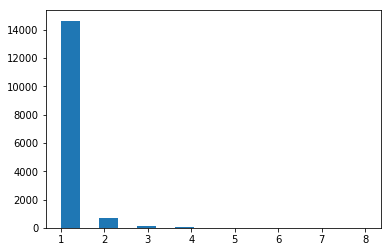

In [9]:
plt.hist(data.RESTAURANT_ID.value_counts(), bins=16)

### TITLE Column

In [10]:
# Finding Maximum number of TITLES mentioned in a cell

titles = data['TITLE']

maximum = 1
for title in titles :
    split = len(title.split(','))
    if split > maximum:
         maximum = split         
        
print('Maximum Titles in a Cell : ', maximum)


Maximum Titles in a Cell :  2


In [11]:
# Finding the number of unique TITLES and the TITLE names

all_titles_set = set()

for title in titles :
    split = title.split(',')
    for line in split:
        all_titles_set.add(line.strip().lower())
        
print('Number of Unique Titles : ', len(all_titles_set))
print('Unique Titles: ', all_titles_set)

all_titles_list = list(all_titles_set)


Number of Unique Titles :  25
Unique Titles:  {'fine dining', 'cocktail bar', 'confectionery', 'none', 'casual dining', 'bhojanalya', 'food truck', 'meat shop', 'kiosk', 'dhaba', 'beverage shop', 'irani cafe', 'bakery', 'food court', 'paan shop', 'café', 'bar', 'sweet shop', 'lounge', 'dessert parlor', 'pub', 'club', 'quick bites', 'mess', 'microbrewery'}


In [12]:
# Title wise count

all_titles = data['TITLE'].str.split(',')


title_counter = Counter(([a for b in all_titles.tolist() for a in b]))
title_counter

Counter({'CASUAL DINING': 5865,
         'BAR': 900,
         'QUICK BITES': 6144,
         'DESSERT PARLOR': 795,
         'CAFÉ': 1140,
         'MICROBREWERY': 98,
         'BEVERAGE SHOP': 331,
         'IRANI CAFE': 5,
         'BAKERY': 707,
         'None': 1287,
         'PUB': 189,
         'FINE DINING': 468,
         'SWEET SHOP': 218,
         'LOUNGE': 263,
         'FOOD COURT': 144,
         'FOOD TRUCK': 39,
         'MESS': 68,
         'KIOSK': 80,
         'CLUB': 39,
         'CONFECTIONERY': 6,
         'DHABA': 61,
         'MEAT SHOP': 4,
         'COCKTAIL BAR': 7,
         'PAAN SHOP': 6,
         'BHOJANALYA': 1})

In [13]:
# Title wise average cost

title_list = set([a for b in all_titles.tolist() for a in b])
for title in title_list:
    print(title, ": ", data_train[data_train['TITLE'].str.contains(title)]['COST'].mean())


FINE DINING :  2908.7988826815645
SWEET SHOP :  288.7096774193548
COCKTAIL BAR :  2550.0
BAKERY :  366.4454887218045
QUICK BITES :  348.1128751631144
FOOD TRUCK :  273.5483870967742
CAFÉ :  707.1174377224199
MESS :  255.28301886792454
PUB :  1508.695652173913
KIOSK :  225.83333333333334
BAR :  1494.2572674418604
CONFECTIONERY :  360.0
PAAN SHOP :  120.0
MEAT SHOP :  483.3333333333333
BHOJANALYA :  nan
CLUB :  2303.5714285714284
FOOD COURT :  423.8888888888889
DHABA :  387.1111111111111
LOUNGE :  1785.0746268656717
None :  415.55333998005983
IRANI CAFE :  1400.0
MICROBREWERY :  1672.5352112676057
CASUAL DINING :  865.0671386161224
BEVERAGE SHOP :  265.7429718875502
DESSERT PARLOR :  330.8766233766234


### CUISINE Column

In [14]:
# Finding Maximum number of CUISINES mentioned in a cell

cuisines = data['CUISINES']

maximum = 1
for cuisine in cuisines :
    split = len(cuisine.split(','))
    if split > maximum:
         maximum = split         
        
print('Maximum Titles in a Cell : ', maximum)


Maximum Titles in a Cell :  8


In [15]:
# Finding the number of unique CUISINES and the CUISINE names

all_cuisines_set = set()

for cuisine in cuisines :
    split = cuisine.split(',')
    for line in split:
        all_cuisines_set.add(line.strip().lower())
        
print('Number of Unique cuisines : ', len(all_cuisines_set))
print('Unique cuisines: ', all_cuisines_set)

all_cuisines_list = list(all_cuisines_set)


Number of Unique cuisines :  130
Unique cuisines:  {'', 'belgian', 'american', 'malwani', 'street food', 'bubble tea', 'gujarati', 'french', 'ethiopian', 'poké', 'pizza', 'sri lankan', 'malaysian', 'rolls', 'indian', 'healthy food', 'steak', 'kashmiri', 'cafe food', 'african', 'south american', 'andhra', 'rajasthani', 'cantonese', 'vegan', 'hyderabadi', 'multi cuisine', 'kebab', 'middle eastern', 'european', 'continental', 'salad', 'sushi', 'drinks only', 'indonesian', 'biryani', 'cafe', 'thai', 'finger food', 'chettinad', 'maharashtrian', 'roast chicken', 'russian', 'naga', 'pakistani', 'iranian', 'nepalese', 'fusion', 'konkan', 'burger', 'north eastern', 'parsi', 'tamil', 'german', 'mishti', 'mithai', 'moroccan', 'tea', 'asian', 'italian', 'juices', 'wraps', 'dumplings', 'coffee and tea', 'afghan', 'greek', 'fish and chips', 'south indian', 'mongolian', 'british', 'egyptian', 'lucknowi', 'lebanese', 'bohri', 'arabian', 'seafood', 'singaporean', 'jewish', 'japanese', 'peruvian', 'chin

In [16]:
data['CUISINES'] = data['CUISINES'].str.replace(' ', '')
data_temp = data[ : data_train.shape[0]]
data_temp.shape

(12690, 8)

In [17]:
# CUISINES wise count

all_cuisines = data['CUISINES'].str.split(',')
cuisines_counter = Counter(([a for b in all_cuisines.tolist() for a in b]))
cuisines_counter

Counter({'Malwani': 74,
         'Goan': 42,
         'NorthIndian': 7222,
         'Asian': 600,
         'ModernIndian': 87,
         'Japanese': 190,
         'Chinese': 5849,
         'Biryani': 1683,
         'Hyderabadi': 180,
         'Tibetan': 65,
         'Desserts': 1507,
         'Seafood': 768,
         'Cafe': 1115,
         'Pizza': 700,
         'Burger': 493,
         'BarFood': 45,
         'SouthIndian': 3034,
         'FastFood': 2866,
         'Beverages': 1286,
         'Arabian': 534,
         'Mughlai': 1029,
         'Maharashtrian': 95,
         'Parsi': 28,
         'Thai': 427,
         'Bakery': 874,
         'Momos': 493,
         'Continental': 2095,
         'European': 326,
         'Rolls': 348,
         'Andhra': 327,
         'Italian': 1536,
         'BBQ': 215,
         'FingerFood': 374,
         'Tea': 79,
         'American': 388,
         'HealthyFood': 290,
         'Coffee': 63,
         'Indonesian': 23,
         'Korean': 46,
         'Nepa

In [18]:
cuisines_list = set([a for b in all_cuisines.tolist() for a in b])

for cuisine in cuisines_list:
    print(cuisine, ": ", data_train[data_temp['CUISINES'].str.contains(cuisine)]['COST'].mean())

 :  655.2522458628841
Cafe :  704.311377245509
SouthIndian :  516.9846086191733
Awadhi :  1265.7894736842106
Armenian :  2000.0
Tea :  449.2647058823529
Falafel :  nan
Rolls :  400.32
Sindhi :  800.0
European :  1736.6795366795366
Irish :  2500.0
Jewish :  700.0
Korean :  1476.388888888889
Dumplings :  950.0
MultiCuisine :  600.0
MiddleEastern :  941.6666666666666
Indonesian :  1277.7777777777778
Paan :  120.0
Asian :  1460.972850678733
Greek :  1650.0
Hawaiian :  nan
Continental :  1203.345489443378
Sandwich :  435.02024291497975
RoastChicken :  387.5
Cantonese :  2733.3333333333335
ModernAustralian :  2200.0
Mithai :  298.41269841269843
French :  1295.2380952380952
Goan :  1098.4848484848485
BBQ :  908.2857142857143
Pakistani :  1500.0
Tamil :  425.0
Peruvian :  2850.0
Fusion :  300.0
Naga :  664.2857142857143
Kerala :  494.9126213592233
Grill :  650.0
Oriental :  3000.0
Malaysian :  1282.9268292682927
Afghan :  691.6666666666666
Vegan :  700.0
Gujarati :  812.7906976744187
CuisineVa

### CITY Column

In [19]:
cities = data_temp['CITY']

all_cities_set = set(map(lambda city : "none" if (type(city) == float) else city.strip().lower(), cities))

print('Number of Unique cities (Including None): ', len(all_cities_set))
print('Unique Cities: ', all_cities_set)
 
all_cities_list = list(all_cities_set)

Number of Unique cities (Including None):  355
Unique Cities:  {'banaswadi (next to indian bank) bangalore', 'hosur road', 'borivali west', 'sector 1', 'chennai 600034.', 'mumbai', 'navi-mumbai', 'naya nagar mira road', 'banjara hills', 'indiranagar', 'telangana 500081', 'chennai (bang opposite indian bank)', 'mehdipatnam', 'kolathur', 'ramapuram', 'bhayandar', 'vadapalani.', 'kochi kakkanad', 'karnataka 560102', '10th avenue', '682035.', 'andheri lokhandwala.', 'uppal', 'ulsoo', 'grant road west', 'khar west', 'panampilly nagar', 'borivali west.', 'kerala 682013', 'hyderabad.', 'arumbakkam chennai-600106.', 'thanisandra', 'west mumbai', 'btm bangalore', 'ecr neelankarai chennai 600115', 'thane (w)', 'off brigade road', 'veliaveetil house vivekananda nagar elamakkara', 'pvr plaza cinema building connaught place', 'chennai-40', 'nedumbassery', 'telangana 500034', 'rohini', 'gurgaon', 'malad east', 'pitampura', 'secunderabad main road near signal nmrec college', 'gurgoan', 'maharashtra',

### LOCALITY Column

In [20]:
localites = data_temp['LOCALITY']

all_localities_set = set(map(lambda locality : "none" if (type(locality) == float) else locality.strip().lower(), localites))

print('Number of Unique cities (Including None): ', len(all_localities_set))
print('Unique Cities: ', all_localities_set)
 
all_cities_list = list(all_localities_set)

Number of Unique cities (Including None):  1399
Unique Cities:  {'shop 4 sai smruti building vazira naka near sbi atm l.t. road borivali west', 'nishat bagh colony', '6th phase jp nagar', 'near feroze shah road', 't. nagar', 'r k puram', 'khopat', 'west k.k. nagar', 'new hafeezpet', '5th avenue', 'near andhra prabha office', 'indiranagar', 'hal 3rd stage', 'ramapuram', 'mehdipatnam', 'khanamet', 'ejipura rama temple road', 'porur', 'gwal pahari', 'opposite to rishi degree college', 'egmore', 'sector 21 c', 'railway road', 'in front of rajiv chowk metro gate no -5', 'sector 93', 'near raj nagar', 'inirapuram habitat centre', 'koramangala 2nd block', 'kothapet', 'mandaveli', 'pitampura', 'okhla phase 2', 'kaloor - kadavanthara road', 'opposite ruby hospital jogeshwari', 'jose junction', 'rathna nagar', 'rmv 2 stage', 'mysore road', 'near perambur', 'thippasandra', '65/3794 b ponoth lane kaloor', 'malleshwaram west', 'near palam', 'sector 70', 'raj nagar', 'adyar', 'bhyander east', 's p r

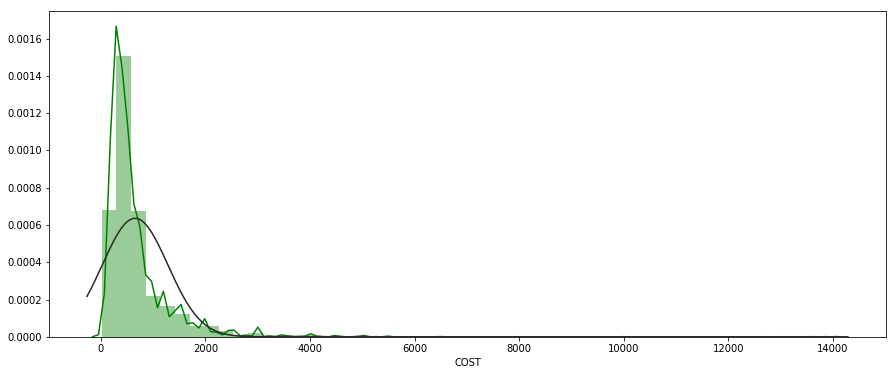

In [21]:
plt.figure(figsize=(15, 6))
sns.distplot(data_train['COST'], fit = norm, color = 'Green')

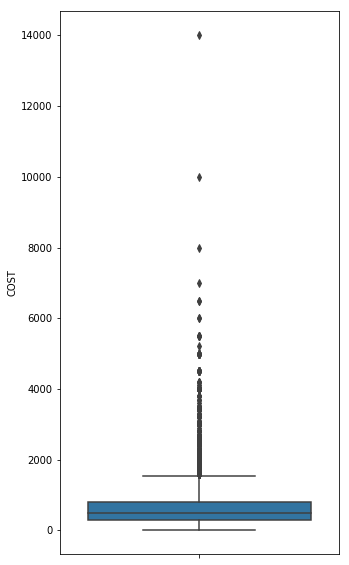

In [22]:
plt.figure(figsize=(5, 10))
sns.boxplot(y = 'COST', data = data_train)

# Data Cleaning

After the analysis we will proceed to cleaning the training and test sets.

The following steps are performed for both data_train and data_test

* For columns TITLE, CUISINES, CITY, LOCALITY, TIME merged similar values to reduce variations.
* New columns with time period was derived from TIME column.
* Replacing NANs in CITY and LOCALITY with text "None".
* Converting RATING type to float.
* Cleaning the VOTES column and converting it to float.
* Replacing NaNs of RATING and VOTES column using groupby mean values of each CITY and LOCALITY.
* The cleaned features are stored to a new dataset.(data_train_new & data_test_new).

### TITLE Column

In [ ]:
# Merging similar titles to reduce variations

title_replace_list = {'PUB':'BAR', 'MICROBREWERY':'BAR', 'IRANI CAFE':'CAFÉ', 'BHOJANALYA':'MESS', 'CONFECTIONERY':'BAKERY',
                      'DESSERT PARLOR':'BAKERY', 'SWEET SHOP':'BAKERY', 'FOOD COURT':'QUICK BITES', 'KIOSK':'MESS',
                      'CLUB':'FINE DINING', 'COCKTAIL BAR':'FINE DINING', 'DHABA':'QUICK BITES', 'PAAN SHOP':'None',
                      'MEAT SHOP':'QUICK BITES', 'FOOD TRUCK':'QUICK BITES', 'LOUNGE':'BAR'}

data['TITLE'] = data['TITLE'].replace(title_replace_list)

In [24]:
all_titles = data['TITLE'].str.split(',')
title_counter = Counter(([a for b in all_titles.tolist() for a in b]))
title_counter

Counter({'CASUAL DINING': 5865,
         'BAR': 1450,
         'QUICK BITES': 6392,
         'BAKERY': 1726,
         'CAFÉ': 1145,
         'BEVERAGE SHOP': 331,
         'None': 1293,
         'FINE DINING': 514,
         'MESS': 149})

### CUISINES Column

In [23]:
# Merging similar cusines to reduce title variations


cuisines_replace_list = {'bihari':'regional_400', 'bohri':'regional_400', 'tamil':'regional_400', 'oriya':'regional_400',
                      'kerala':'regional_400', 'panini':'sandwich', 'charcoalchicken':'sandwich', 'bengali':'regional_650',
                      'chettinad':'regional_650', 'maharashtrian':'regional_650', 'nepalese':'regional_650',
                      'andhra':'regional_650', 'hotpot':'regional_650', 'pizza':'regional_650', 'chinese':'regional_650',
                      'vegan':'regional_650', 'cafe':'regional_650', 'cafefood':'regional_650', 'healthyfood':'',
                      'lebanese':'kebab', 'turkish':'kebab', 'mangalorean':'seafood', 'konkan':'seafood', 'thai':'seafood',
                      'parsi':'seafood', 'srilankan':'seafood', 'korean':'asian', 'singaporean':'asian', 'sushi':'asian',
                      'vietnamese':'asian', 'malaysian':'asian', 'indonesian':'asian', 'modernindian':'asian',
                      'mediterranean':'european', 'spanish':'european', 'barfood':'european', 'fingerfood':'european',
                      'japanese':'european', 'greek':'european', 'drinksonly':'european', 'peruvian':'european',
                      'cantonese':'european', 'egyptian':'european', 'moroccan':'european', 'irish':'european',
                      'Malwani':'Regional', 'BubbleTea':'Desserts', 'CoffeeandTea':'Beverages', 'Hyderabadi':'Biryani',
                      'Goan':'Regional', 'Thai':'Asian', 'Japanese':'Asian', 'BarFood':'FastFood', 'Juices':'Beverages',
                      'Bakery':'Desserts', 'Tibetan':'Asian', 'ModernIndian':'European', 'Pizza':'FastFood','Burger':'FastFood',
                      'Maharashtrian':'Regional', 'Parsi':'Regional', 'Thai':'Asian', 'Momos':'FastFood', 'Rolls':'FastFood',
                      'Italian':'European', 'Andhra':'Regional', 'BBQ':'European', 'FingerFood':'FastFood', 'Tea':'Beverages',
                      'American':'European', 'HealthyFood':'Salad', 'Coffee':'Beverages', 'Indonesian':'Asian','Korean':'Asian',
                      'Nepalese':'Asian', 'Mexican':'European', 'IceCream':'Desserts', 'Kerala':'Regional', 'Mithai':'Desserts',
                      'StreetFood':'FastFood', 'Malaysian':'Asian', 'Vietnamese':'Asian', 'Arabian':'European',
                      'Iranian':'European', 'Kebab':'FastFood', 'Sandwich':'FastFood', 'Mediterranean':'European',
                      'Gujarati':'Regional', 'Rajasthani':'Regional', 'Tex-Mex':'European', 'RoastChicken':'European',
                      'Chettinad':'Regional', 'NorthEastern':'Regional', 'Lebanese':'European', 'Grill':'European',
                      'Bihari':'Regional', 'Bengali':'Regional','Lucknowi':'Regional', 'Awadhi':'Regional', 'Steak':'European',
                      'French':'European', 'Portuguese':'European', 'Wraps':'FastFood', 'SriLankan':'Asian', 'Oriya':'Regional',
                      'Ethiopian':'European', 'Konkan':'Regional', 'Sushi':'Asian', 'Spanish':'European', 'Russian':'European',
                      'Mangalorean':'Regional', 'Turkish':'European', 'Naga':'Regional', 'Singaporean':'Asian',
                      'German':'European', 'MiddleEastern':'European', 'Sindhi':'Regional', 'Cantonese':'Asian',
                      'HotPot':'Asian', 'Kashmiri':'Regional', 'British':'European', 'PanAsian':'Asian', 'Satay':'Asian',
                      'Dumplings':'FastFood', 'RawMeats':'FastFood', 'DrinksOnly':'Beverages', 'CafeFood':'Cafe',
                      'Hotdogs':'FastFood', 'Burmese':'Asian', 'Afghan':'European', 'SouthEuropean':'European'}

data['CUISINES'] = data['CUISINES'].replace(cuisines_replace_list)

In [26]:
regional_replace = ['Tamil','Assamese','Bohri','Mishti']
for cuisine in regional_replace:
    data['CUISINES'] = data['CUISINES'].str.replace(cuisine,'Regional')

In [27]:
cuisine_df = pd.DataFrame.from_dict(cuisines_counter, orient='index').reset_index()
cuisine_df.columns = ['cuisine', 'counts']

european_replace = list(cuisine_df[cuisine_df.counts <= 10]['cuisine'])

for cuisine in european_replace:
    data['CUISINES'] = data['CUISINES'].str.replace(cuisine,'European')

In [28]:
data['CUISINES'] = data['CUISINES'].str.replace('NorthIndian', 'Northindian')
data['CUISINES'] = data['CUISINES'].str.replace('SouthIndian', 'Southindian')
data['CUISINES'] = data['CUISINES'].str.replace('Indian', 'Northindian')

In [29]:
all_cuisines = data['CUISINES'].str.split(',')
cuisines_counter = Counter(([a for b in all_cuisines.tolist() for a in b]))
del cuisines_counter['']
cuisines_counter

Counter({'Regional': 1916,
         'Northindian': 7278,
         'Asian': 1602,
         'European': 4200,
         'Chinese': 5849,
         'Biryani': 1863,
         'Desserts': 2857,
         'Seafood': 768,
         'Cafe': 1121,
         'FastFood': 6879,
         'Southindian': 3034,
         'Beverages': 1763,
         'Mughlai': 1029,
         'Continental': 2095,
         'Salad': 628,
         'Miseafood': 257})

### TIME Column

In [30]:
data.TIME = data.TIME.str.lower()
data.TIME = data.TIME.str.replace(' ', '')
data.TIME = data.TIME.str.replace('–', '-')

data['all_days'] = 0
data.loc[data.TIME.str.contains(r'(\(mon\-sun\))'), 'all_days'] = 1
data.TIME = data.TIME.str.replace('\(mon-sun\)', '')

data['closed_weekend'] = 0
data.loc[data.TIME.str.contains("closed\(sun\)"), "closed_weekend"] = 1
data.loc[data.TIME.str.contains("closed\(sat\)"), "closed_weekend"] = 1
data.TIME = data.TIME.str.replace("closed\(sun\)", "")
data.TIME = data.TIME.str.replace("closed\(sat\)", "")

data['closed_weekday'] = 0
data.loc[data.TIME.str.contains("closed\(mon\)"),"closed_weekday"] = 1
data.loc[data.TIME.str.contains("closed\(tue\)"),"closed_weekday"] = 1
data.loc[data.TIME.str.contains("closed\(wed\)"),"closed_weekday"] = 1
data.TIME = data.TIME.str.replace("closed\(mon\)","")
data.TIME = data.TIME.str.replace("closed\(tue\)","")
data.TIME = data.TIME.str.replace("closed\(wed\)","")

#data.TIME = data.TIME.str.replace(",",' ')
data.TIME = data.TIME.str.replace("(",' ')

data.TIME = data.TIME.str.strip()
data.TIME = data.TIME.str.split(" ").str.get(0).str.lstrip(',')

data.TIME = data.TIME.str.replace("-"," ")
data.TIME = data.TIME.str.replace(","," ")

data.TIME = data.TIME.str.replace("12noon","12:01")
data.TIME = data.TIME.str.replace("12midnight","00:01")
data.TIME[data.TIME.str.contains("24hours")] = "00:01 23:59"
data.TIME[data.TIME.str.contains("notavailable")] = "11am 11pm"
data.TIME[data.TIME.str.contains("mon")] = "11am 11pm"
data.TIME[data.TIME.str.contains("closed")] = "9am 9am"
data.TIME = data.TIME.str.replace(".","")
data.TIME[data.TIME == ""] = "11am 11pm"

a = data.TIME.str.split(' ', expand=True)
a.columns = ["1", "2", "3", "4", "5", "6"]
a['1'] = a['1'].apply(lambda x: parse(x))
a['2'] = a['2'].apply(lambda x: parse(x))
a['3'] = a['3'].apply(lambda x: parse(x) if x is not None else x)
a['4'][a['4']==""] = None
a['6'][a['6']==""] = None
a['4'] = a['4'].apply(lambda x: parse(x) if x is not None else x)
a['5'] = a['5'].apply(lambda x: parse(x) if x is not None else x)
a['6'] = a['6'].apply(lambda x: parse(x) if x is not None else x)

a['2'] = a.apply(lambda row: row['2']+datetime.timedelta(days = 1) if (row['2']-row['1']) < datetime.timedelta(minutes = 1)
                 else row['2'], axis = 1)
a['3'] = a.apply(lambda row: row['3']+datetime.timedelta(days = 1) if (row['3']-row['1']) < datetime.timedelta(minutes = 1)
                 else row['3'], axis = 1)
a['4'] = a.apply(lambda row: row['4']+datetime.timedelta(days = 1) if (row['3']-row['1']) < datetime.timedelta(minutes = 1)
                 else row['4'], axis = 1)

a['2-1'] = a['2']-a['1']
a['4-3'] = a['4']-a['3']
a['6-5'] = a['6']-a['5']

a['4-3'].fillna(0, inplace = True)
a['6-5'].fillna(0, inplace = True)
a['duration'] = a['2-1']+a['4-3']+a['6-5']
a['closing_time'] = a[["2", "4", "6"]].max(axis = 1).dt.time
a['opening_time'] = a['1'].dt.time


### CITY Column

In [31]:
data['CITY'] = data['CITY'].str.lower()
data['CITY'][data['CITY'].isnull()] = "None"

all_cities = data['CITY'].value_counts().index[:9].tolist()
for city in all_cities:
    data.CITY[data.CITY.str.contains(city)] = city
    
all_cities

['chennai',
 'bangalore',
 'hyderabad',
 'mumbai',
 'kochi',
 'new delhi',
 'gurgaon',
 'secunderabad',
 'noida']

In [32]:
data['CITY'][data['CITY'] == 'india'] = 'None'
data['CITY'][data['CITY'].str.contains('thane')] = 'mumbai'
data['CITY'][data['CITY'].str.contains('bandra')] = 'mumbai'
data['CITY'][data['CITY'].str.contains('andheri')] = 'mumbai'
data['CITY'][data['CITY'].str.contains('bengaluru')] = 'bangalore'
data['CITY'][data['CITY'].str.contains('kakkanad')] = 'kochi'
data['CITY'][data['CITY'].str.contains('ernakulam')] = 'kochi'
data['CITY'][data['CITY'].str.contains('madhapur')] = 'kochi'
data['CITY'][data['CITY'].str.contains('edappally')] = 'kochi'
data['CITY'][data['CITY'].str.contains('kaloor')] = 'kochi'
data['CITY'][data['CITY'] == 'kerala'] = 'kochi'
data['CITY'][data['CITY'] == 'telangana'] = 'hyderabad'
data['CITY'][data['CITY'] == 'jubilee hills'] = 'hyderabad'
data['CITY'][data['CITY'] == 'gurugram'] = 'gurgaon'
data['CITY'][data['CITY'] == 'banglore'] = 'bangalore'
data['CITY'][data['CITY'] == 'bengalore'] = 'bangalore'
data['CITY'][data['CITY'] == 'dwarka'] = 'new delhi'
data.loc[data['CITY']=='delhi ncr',"CITY"] = "new delhi" 
data['CITY'][data['CITY'] == 'dwarka'] = 'new delhi'
data['CITY'][data['CITY'] == 'delhi'] = 'new delhi'
data['CITY'][data['CITY'] == 'maharashtra'] = 'mumbai'
data['CITY'][data['CITY'] == 'tamil nadu'] = 'chennai'
data['CITY'][data['CITY'] == 'hsr layout'] = 'bangalore'
data['CITY'][data['CITY'] == 'palarivattom'] = 'kochi'
data['CITY'][data['CITY'] == 'powai'] = 'mumbai'
data['CITY'][data['CITY'] == 'aluva'] = 'kochi'
data['CITY'][data['CITY'] == 'ambattur'] = 'chennai'
data['CITY'][data['CITY'] == 'jp nagar'] = 'bangalore'
data['CITY'][data['CITY'] == 'velachery'] = 'chennai'
data['CITY'][data['CITY'] == 'indiranagar'] = 'bangalore'
data['CITY'][data['CITY'] == 'marathahalli'] = 'bangalore'
data['CITY'][data['CITY'] == 'nungambakkam'] = 'chennai'
data['CITY'][data['CITY'] == 'banjara hills'] = 'hyderabad'
data['CITY'][data['CITY'] == 'panampilly nagar'] = 'kochi'
data['CITY'][data['CITY'] == 'kalyan west'] = 'mumbai'
data['CITY'][data['CITY'] == 'manikonda'] = 'hyderabad'
data['CITY'][data['CITY'] == 'aluva circle'] = 'kochi'
data['CITY'][data['CITY'] == 'tripunithura'] = 'kochi'
data['CITY'][data['CITY'] == 'vyttila'] = 'kochi'
data['CITY'][data['CITY'] == 'kukatpally'] = 'hyderabad'
data['CITY'][data['CITY'] == 'sarjapur'] = 'bangalore'
data['CITY'][data['CITY'] == 'maharashtra.'] = 'mumbai'
data['CITY'][data['CITY'] == 'delh.'] = 'new delhi'
data['CITY'][data['CITY'] == 'kadavanthra'] = 'kochi'
data['CITY'][data['CITY'] == 'telangana 500070'] = 'hyderabad'
data['CITY'][data['CITY'] == 'banglaore'] = 'bangalore'
data['CITY'][data['CITY'] == 'mahim'] = 'mumbai'
data['CITY'][data['CITY'] == 'vandalur'] = 'chennai'
data['CITY'][data['CITY'] == 'faridabd'] = 'faridabad'
data['CITY'][data['CITY'] == 'nizampet'] = 'hyderabad'
data['CITY'][data['CITY'] == 'mahadevpura'] = 'bangalore'
data['CITY'][data['CITY'] == 'kanakapura road banglore'] = 'bangalore'
data['CITY'][data['CITY'] == 'kalamassery'] = 'kochi'
data['CITY'][data['CITY'] == 'chepauk'] = 'chennai'
data['CITY'][data['CITY'] == 'marad'] = 'kochi'
data['CITY'][data['CITY'] == 'chullickal'] = 'kochi'
data['CITY'][data['CITY'] == 'thanisandra'] = 'bangalore'
data['CITY'][data['CITY'] == 'bangalor'] = 'bangalore'
data['CITY'][data['CITY'] == 'old delhi'] = 'new delhi'
data['CITY'][data['CITY'] == 'kalyan'] = 'mumbai'
data['CITY'][data['CITY'] == 'outer ring road'] = 'bangalore'
data['CITY'][data['CITY'] == 'telangana 500003'] = 'hyderabad'
data['CITY'][data['CITY'] == 'miumbai'] = 'mumbai'
data['CITY'][data['CITY'] == 'kerala 682305'] = 'kochi'
data['CITY'][data['CITY'] == 'vadapalani.'] = 'chennai'
data['CITY'][data['CITY'] == 'nedumbassery'] = 'kochi'
data['CITY'][data['CITY'] == 'marine drive'] = 'kochi'
data['CITY'][data['CITY'] == 'maharashtra 400092'] = 'mumbai'
data['CITY'][data['CITY'] == 'malad east'] = 'mumbai'
data['CITY'][data['CITY'] == 'church street'] = 'bangalore'
data['CITY'][data['CITY'] == 'btm 1st stage'] = 'bangalore'
data['CITY'][data['CITY'] == 'near jyothinivas college'] = 'bangalore'
data['CITY'][data['CITY'] == 'hyderaba'] = 'bangalore'
data['CITY'][data['CITY'] == 'vadapalani'] = 'chennai'
data['CITY'][data['CITY'] == 'delhi 110085'] = 'new delhi'
data['CITY'][data['CITY'] == 'avadi'] = 'chennai'
data['CITY'][data['CITY'] == 'chenn ai'] = 'chennai'
data['CITY'][data['CITY'] == 'vadapalani.'] = 'chennai'
data['CITY'][data['CITY'] == 'btm'] = 'bangalore'
data['CITY'][data['CITY'] == 'btm layout'] = 'bangalore'
data['CITY'][data['CITY'] == 'maharashtra 400102'] = 'mumbai'
data['CITY'][data['CITY'] == '1st tavarekere'] = 'bangalore'
data['CITY'][data['CITY'] == 'telengana'] = 'hyderabad'
data['CITY'][data['CITY'] == 'telangana 500032'] = 'hyderabad'
data['CITY'][data['CITY'] == 'tamil nadu 600102'] = 'chennai'
data['CITY'][data['CITY'] == 'whitefield'] = 'bangalore'
data['CITY'][data['CITY'] == 'hosur road'] = 'bangalore'
data['CITY'][data['CITY'] == 'kerala 682015'] = 'kochi'
data['CITY'][data['CITY'] == 'anna nagar east'] = 'chennai'
data['CITY'][data['CITY'] == 'karnataka 560102'] = 'bangalore'
data['CITY'][data['CITY'] == 'telangana 500027'] = 'hyderabad'
data['CITY'][data['CITY'] == 'perumbavoor'] = 'kochi'
data['CITY'][data['CITY'] == 'tavarekere main road'] = 'bangalore'
data['CITY'][data['CITY'] == 'omr karapakkam'] = 'chennai'
data['CITY'][data['CITY'] == 'elamakkara'] = 'kochi'
data['CITY'][data['CITY'] == 'kerala 683585'] = 'kochi'
data['CITY'][data['CITY'] == 'kerala 682021'] = 'kochi'
data['CITY'][data['CITY'] == 'kerala 682018'] = 'kochi'
data['CITY'][data['CITY'] == 'kukatapally'] = 'hyderabad'
data['CITY'][data['CITY'] == 'karnataka 560103'] = 'bangalore'
data['CITY'][data['CITY'] == 'karnataka 560037'] = 'bangalore'
data['CITY'][data['CITY'] == 'thevera'] = 'bangalore'
data['CITY'][data['CITY'] == 'telangana 500034'] = 'hyderabad'
data['CITY'][data['CITY'] == 'kerala 683104'] = 'kochi'
data['CITY'][data['CITY'] == 'kerala 682001 india'] = 'kochi'
data['CITY'][data['CITY'] == 'alwarpet'] = 'chennai'
data['CITY'][data['CITY'] == 'ulsoo'] = 'bangalore'
data['CITY'][data['CITY'] == 'kerala 682024'] = 'kochi'
data['CITY'][data['CITY'] == 'perungudi'] = 'chennai'
data['CITY'][data['CITY'] == 'chenna'] = 'chennai'
data['CITY'][data['CITY'] == 'brigade road'] = 'bangalore'
data['CITY'][data['CITY'] == 'kerala 690525'] = 'kochi'
data['CITY'][data['CITY'] == 'telangana 500081'] = 'hyderabad'
data['CITY'][data['CITY'] == 'khar (west)'] = 'mumbai'
data['CITY'][data['CITY'] == 'borivali west'] = 'mumbai'
data['CITY'][data['CITY'] == 'malapallipuram p .o thrissur'] = 'kochi'
data['CITY'][data['CITY'] == 'palavakkam'] = 'chennai'
data['CITY'][data['CITY'] == 'hbr layout'] = 'bangalore'
data['CITY'][data['CITY'] == 'kerala 682028'] = 'kochi'
data['CITY'][data['CITY'] == 'gachibowli'] = 'hyderabad'
data['CITY'][data['CITY'] == 'kilpauk'] = 'chennai'
data['CITY'][data['CITY'] == 'karnataka'] = 'bangalore'
data['CITY'][data['CITY'] == 'potheri'] = 'chennai'
data['CITY'][data['CITY'] == 'dilsukhnagar'] = 'hyderabad'
data['CITY'][data['CITY'] == 'rohini'] = 'new delhi'
data['CITY'][data['CITY'] == 'mulund west'] = 'mumbai'
data['CITY'][data['CITY'] == 'mahabalipuram'] = 'chennai'
data['CITY'][data['CITY'] == 'karnataka 560043'] = 'bangalore'
data['CITY'][data['CITY'] == 'lingampally'] = 'hyderabad'
data['CITY'][data['CITY'] == 'kondapur'] = 'hyderabad'
data['CITY'][data['CITY'] == 'kerala 682022'] = 'kochi'
data['CITY'][data['CITY'] == 'kerala 682304'] = 'kochi'
data['CITY'][data['CITY'] == '682035.'] = 'kochi'
data['CITY'][data['CITY'] == 'mulund east'] = 'mumbai'
data['CITY'][data['CITY'] == 'gst road'] = 'chennai'
data['CITY'][data['CITY'] == '1st stage'] = 'bangalore'
data['CITY'][data['CITY'] == 'anna nagar west'] = 'chennai'

In [33]:
data.loc[data["CITY"].isin(data['CITY'].value_counts()[data['CITY'].value_counts() <= 2].index.tolist()),"CITY"] = "None"

In [34]:
city_list = data['CITY'].str.split('\n')
city_counter = Counter(([a for b in city_list.tolist() for a in b]))
city_counter

Counter({'mumbai': 2943,
         'chennai': 2938,
         'bangalore': 2979,
         'gurgaon': 535,
         'hyderabad': 2522,
         'kochi': 1887,
         'new delhi': 1811,
         'None': 347,
         'noida': 316,
         'secunderabad': 401,
         'faridabad': 110,
         'ghaziabad': 132})

### LOCALITY Column

In [35]:
data['LOCALITY'] = data['LOCALITY'].str.lower()
data['LOCALITY'][data['LOCALITY'].isnull()] = "none"
data['LOCALITY'] = data['LOCALITY'].str.replace('.', '')

In [36]:
data['LOCALITY'] = data['LOCALITY'].str.replace(' west','')
data['LOCALITY'] = data['LOCALITY'].str.replace(' east','')
#data['LOCALITY'] = data['LOCALITY'].str.replace(' phase','')
#data['LOCALITY'] = data['LOCALITY'].str.replace(' hills','')
#data['LOCALITY'] = data['LOCALITY'].str.replace(' city','')
#data['LOCALITY'] = data['LOCALITY'].str.replace(' road','')
#data['LOCALITY'] = data['LOCALITY'].str.replace(' nagar','')
#data['LOCALITY'] = data['LOCALITY'].str.replace(' park','')
#data['LOCALITY'] = data['LOCALITY'].str.replace(' block','')

data['LOCALITY'][data['LOCALITY'] == 'koramangala 5th block'] = 'koramangala'
data['LOCALITY'][data['LOCALITY'].str.contains('greater kailash')] = 'greater kailash'
data['LOCALITY'][data['LOCALITY'] == 'fort'] = 'fort kochi'
data['LOCALITY'][data['LOCALITY'] == 'nit'] = 'nit university'
data['LOCALITY'][data['LOCALITY'] == 'kochi'] = 'fort kochi'
data['LOCALITY'][data['LOCALITY'] == 'koti'] = 'kotikoti'
data['LOCALITY'][data['LOCALITY'] == 'parel'] = 'parelparel'
data['LOCALITY'] = data['LOCALITY'].str.replace(' ', '')

In [37]:
all_localities = data['LOCALITY'].value_counts()[data['LOCALITY'].value_counts() >= 70].index.tolist()

for locality in all_localities:
    data['LOCALITY'][data['LOCALITY'].str.contains(locality)] = locality

### RATING Column

In [38]:
data.RATING = data.RATING.replace("NEW", np.nan)
data.RATING = data.RATING.replace("-", np.nan)
data.RATING = data.RATING.astype('float')
data.RATING.isnull().sum()

1606

### VOTES Column

In [39]:
data.VOTES = data.VOTES.str.replace(" votes", "")
data.VOTES = data.VOTES.astype('float')
data.VOTES.isnull().sum()

1606

In [40]:
# Filling missing values using groupby mean values of each city and locality

data.RATING.fillna(data.groupby(['CITY', 'LOCALITY'])['RATING'].transform('mean'), inplace = True)
data.VOTES.fillna(data.groupby(['CITY', 'LOCALITY'])['VOTES'].transform('mean'), inplace = True)
data.RATING.fillna(data.RATING.mean(), inplace = True)
data.VOTES.fillna(data.VOTES.mean(), inplace = True)

In [41]:
data['sum_rating'] = data['RATING']*data['VOTES']

In [42]:
data.head()

,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES,all_days,closed_weekend,closed_weekday,sum_rating
0,CASUAL DINING,9438,"Regional,Regional,Northindian",11am 4pm 7:30pm 11:30pm,mumbai,dombivali,3.6,49.0,1,0,0,176.4
1,"CASUAL DINING,BAR",13198,"Asian,European,Asian",6pm 11pm,chennai,ramapuram,4.2,30.0,1,0,0,126.0
2,CASUAL DINING,10915,"Northindian,Chinese,Biryani,Biryani",11am 3:30pm 7pm 11pm,chennai,saligramam,3.8,221.0,1,0,0,839.8
3,QUICK BITES,6346,"Asian,Chinese",11:30am 1am,mumbai,bandra,4.1,24.0,1,0,0,98.4
4,BAKERY,15387,Desserts,11am 1am,mumbai,lowerparel,3.8,165.0,1,0,0,627.0


# Data Preprocessing

The below code deals with the following tasks:

1. Encoding categorical features
    * OneHotEncoder
    * Pandas get_dummies
2. Removing unwanted columns 
3. Feature Scaling

## 1. Encoding categorical features

### TITLE Column

In [43]:
for title in title_counter.keys():
    data[title] = 0
    data.loc[data['TITLE'].str.contains(title), title] = 1

In [44]:
print(data.shape)
data.head()

(16921, 21)


,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES,all_days,closed_weekend,...,sum_rating,CASUAL DINING,BAR,QUICK BITES,BAKERY,CAFÉ,BEVERAGE SHOP,None,FINE DINING,MESS
0,CASUAL DINING,9438,"Regional,Regional,Northindian",11am 4pm 7:30pm 11:30pm,mumbai,dombivali,3.6,49.0,1,0,...,176.4,1,0,0,0,0,0,0,0,0
1,"CASUAL DINING,BAR",13198,"Asian,European,Asian",6pm 11pm,chennai,ramapuram,4.2,30.0,1,0,...,126.0,1,1,0,0,0,0,0,0,0
2,CASUAL DINING,10915,"Northindian,Chinese,Biryani,Biryani",11am 3:30pm 7pm 11pm,chennai,saligramam,3.8,221.0,1,0,...,839.8,1,0,0,0,0,0,0,0,0
3,QUICK BITES,6346,"Asian,Chinese",11:30am 1am,mumbai,bandra,4.1,24.0,1,0,...,98.4,0,0,1,0,0,0,0,0,0
4,BAKERY,15387,Desserts,11am 1am,mumbai,lowerparel,3.8,165.0,1,0,...,627.0,0,0,0,1,0,0,0,0,0


### CUISINES Column

In [45]:
for cuisine in cuisines_counter.keys():
    data[cuisine] = 0
    data.loc[data['CUISINES'].str.contains(cuisine), cuisine] = 1

In [46]:
print(data.shape)
data.head()

(16921, 37)


,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES,all_days,closed_weekend,...,Desserts,Seafood,Cafe,FastFood,Southindian,Beverages,Mughlai,Continental,Salad,Miseafood
0,CASUAL DINING,9438,"Regional,Regional,Northindian",11am 4pm 7:30pm 11:30pm,mumbai,dombivali,3.6,49.0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,"CASUAL DINING,BAR",13198,"Asian,European,Asian",6pm 11pm,chennai,ramapuram,4.2,30.0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,CASUAL DINING,10915,"Northindian,Chinese,Biryani,Biryani",11am 3:30pm 7pm 11pm,chennai,saligramam,3.8,221.0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,QUICK BITES,6346,"Asian,Chinese",11:30am 1am,mumbai,bandra,4.1,24.0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,BAKERY,15387,Desserts,11am 1am,mumbai,lowerparel,3.8,165.0,1,0,...,1,0,0,0,0,0,0,0,0,0


### TIME Column

In [47]:
a['late_night'] = 0
a.loc[(a.closing_time >= datetime.time(23, 45, 0)) | ((a.closing_time > datetime.time(0, 0, 0)) & 
                                                      (a.closing_time<=datetime.time(5, 0, 0))), 'late_night'] = 1


a['breakfast'] = 0
a.loc[((a.opening_time > datetime.time(6, 0, 0)) & (a.opening_time < datetime.time(11, 0, 0))), 'breakfast'] = 1


In [48]:
data['breakfast'] = a['breakfast']
data['late_night'] = a['late_night']
data['duration'] = a['duration'].dt.seconds/60

In [49]:
print(data.shape)
data.head()

(16921, 40)


,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES,all_days,closed_weekend,...,FastFood,Southindian,Beverages,Mughlai,Continental,Salad,Miseafood,breakfast,late_night,duration
0,CASUAL DINING,9438,"Regional,Regional,Northindian",11am 4pm 7:30pm 11:30pm,mumbai,dombivali,3.6,49.0,1,0,...,0,0,0,0,0,0,0,0,0,540.0
1,"CASUAL DINING,BAR",13198,"Asian,European,Asian",6pm 11pm,chennai,ramapuram,4.2,30.0,1,0,...,0,0,0,0,0,0,0,0,0,300.0
2,CASUAL DINING,10915,"Northindian,Chinese,Biryani,Biryani",11am 3:30pm 7pm 11pm,chennai,saligramam,3.8,221.0,1,0,...,0,0,0,0,0,0,0,0,0,510.0
3,QUICK BITES,6346,"Asian,Chinese",11:30am 1am,mumbai,bandra,4.1,24.0,1,0,...,0,0,0,0,0,0,0,0,1,810.0
4,BAKERY,15387,Desserts,11am 1am,mumbai,lowerparel,3.8,165.0,1,0,...,0,0,0,0,0,0,0,0,1,840.0


### CITY Column

In [50]:
for city in city_counter.keys():
    data[city] = 0
    data.loc[data['CITY'].str.contains(city), city] = 1

In [51]:
print(data.shape)
data.head()

(16921, 51)


,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES,all_days,closed_weekend,...,chennai,bangalore,gurgaon,hyderabad,kochi,new delhi,noida,secunderabad,faridabad,ghaziabad
0,CASUAL DINING,9438,"Regional,Regional,Northindian",11am 4pm 7:30pm 11:30pm,mumbai,dombivali,3.6,49.0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,"CASUAL DINING,BAR",13198,"Asian,European,Asian",6pm 11pm,chennai,ramapuram,4.2,30.0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,CASUAL DINING,10915,"Northindian,Chinese,Biryani,Biryani",11am 3:30pm 7pm 11pm,chennai,saligramam,3.8,221.0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,QUICK BITES,6346,"Asian,Chinese",11:30am 1am,mumbai,bandra,4.1,24.0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,BAKERY,15387,Desserts,11am 1am,mumbai,lowerparel,3.8,165.0,1,0,...,0,0,0,0,0,0,0,0,0,0


### LOCALITY Column

In [52]:
for locality in all_localities:
    data[locality] = 0
    data.loc[data['LOCALITY'].str.contains(locality), locality] = 1

In [53]:
for locality in data['LOCALITY'].value_counts()[data['LOCALITY'].value_counts() < 6].index.tolist():
    data.LOCALITY[data.LOCALITY == locality] = "none"

In [54]:
locality_list = data['LOCALITY'].str.split('\n')
locality_counter = Counter(([a for b in locality_list.tolist() for a in b]))
locality_counter

Counter({'dombivali': 41,
         'ramapuram': 54,
         'saligramam': 12,
         'bandra': 131,
         'lowerparel': 82,
         'vileparle': 80,
         'koramangala': 268,
         'sector29': 45,
         'bannerghattaroad': 56,
         'dilsukhnagar': 51,
         'indiranagar': 189,
         'chullickal': 26,
         'edappally': 161,
         'none': 1482,
         'jubileehills': 147,
         'borivali': 123,
         'nagole': 8,
         'andheri': 183,
         'krishnanagar': 22,
         'hitechcity': 87,
         'karolbagh': 28,
         'sda': 13,
         'thippasandra': 7,
         'dwarka': 43,
         'kakkanad': 180,
         'hsr': 164,
         'vadapalani': 42,
         'neelangarai': 18,
         'dlfcybercity': 37,
         'versova': 10,
         'palarivattom': 75,
         'tnagar': 247,
         'internationalairport': 12,
         'sholinganallur': 42,
         'mgroad': 140,
         'nungambakkam': 133,
         'krpuram': 21,
         'ko

In [55]:
print(data.shape)
data.head()

(16921, 95)


,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES,all_days,closed_weekend,...,goregaon,marinedrive,lowerparel,vileparle,greaterkailash,vyttila,powai,adyar,palarivattom,alwarpet
0,CASUAL DINING,9438,"Regional,Regional,Northindian",11am 4pm 7:30pm 11:30pm,mumbai,dombivali,3.6,49.0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,"CASUAL DINING,BAR",13198,"Asian,European,Asian",6pm 11pm,chennai,ramapuram,4.2,30.0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,CASUAL DINING,10915,"Northindian,Chinese,Biryani,Biryani",11am 3:30pm 7pm 11pm,chennai,saligramam,3.8,221.0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,QUICK BITES,6346,"Asian,Chinese",11:30am 1am,mumbai,bandra,4.1,24.0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,BAKERY,15387,Desserts,11am 1am,mumbai,lowerparel,3.8,165.0,1,0,...,0,0,1,0,0,0,0,0,0,0


## 3. Droping Columns

In [56]:
print(data.shape)
data.head()

(16921, 95)


,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES,all_days,closed_weekend,...,goregaon,marinedrive,lowerparel,vileparle,greaterkailash,vyttila,powai,adyar,palarivattom,alwarpet
0,CASUAL DINING,9438,"Regional,Regional,Northindian",11am 4pm 7:30pm 11:30pm,mumbai,dombivali,3.6,49.0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,"CASUAL DINING,BAR",13198,"Asian,European,Asian",6pm 11pm,chennai,ramapuram,4.2,30.0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,CASUAL DINING,10915,"Northindian,Chinese,Biryani,Biryani",11am 3:30pm 7pm 11pm,chennai,saligramam,3.8,221.0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,QUICK BITES,6346,"Asian,Chinese",11:30am 1am,mumbai,bandra,4.1,24.0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,BAKERY,15387,Desserts,11am 1am,mumbai,lowerparel,3.8,165.0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [57]:
data.columns

Index(['TITLE', 'RESTAURANT_ID', 'CUISINES', 'TIME', 'CITY', 'LOCALITY',
       'RATING', 'VOTES', 'all_days', 'closed_weekend', 'closed_weekday',
       'sum_rating', 'CASUAL DINING', 'BAR', 'QUICK BITES', 'BAKERY', 'CAFÉ',
       'BEVERAGE SHOP', 'None', 'FINE DINING', 'MESS', 'Regional',
       'Northindian', 'Asian', 'European', 'Chinese', 'Biryani', 'Desserts',
       'Seafood', 'Cafe', 'FastFood', 'Southindian', 'Beverages', 'Mughlai',
       'Continental', 'Salad', 'Miseafood', 'breakfast', 'late_night',
       'duration', 'mumbai', 'chennai', 'bangalore', 'gurgaon', 'hyderabad',
       'kochi', 'new delhi', 'noida', 'secunderabad', 'faridabad', 'ghaziabad',
       'fortkochi', 'gachibowli', 'indiranagar', 'annanagar', 'kakkanad',
       'kukatpally', 'madhapur', 'whitefield', 'banjarahills', 'edappally',
       'hsr', 'marathahalli', 'jubileehills', 'mgroad', 'nungambakkam', 'btm',
       'none', 'andheri', 'kaloor', 'jayanagar', 'tnagar', 'borivali',
       'kondapur', 'korama

In [58]:
data.drop(columns = ['TITLE', 'RESTAURANT_ID', 'CUISINES', 'TIME', 'CITY', 'LOCALITY'], inplace=True)

In [59]:
print(data.shape)
data.head()

(16921, 89)


,RATING,VOTES,all_days,closed_weekend,closed_weekday,sum_rating,CASUAL DINING,BAR,QUICK BITES,BAKERY,...,goregaon,marinedrive,lowerparel,vileparle,greaterkailash,vyttila,powai,adyar,palarivattom,alwarpet
0,3.6,49.0,1,0,0,176.4,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4.2,30.0,1,0,0,126.0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3.8,221.0,1,0,0,839.8,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.1,24.0,1,0,0,98.4,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,3.8,165.0,1,0,0,627.0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0


In [60]:
data_final = pd.get_dummies(data)
data_final.shape

(16921, 89)

In [61]:
train = data_final[ : data_train.shape[0]]
test = data_final[data_train.shape[0] : ]

## 4. Feature Scaling

In [62]:
sc = StandardScaler()

x_train = sc.fit_transform(train)
x_test = sc.transform(test)

y_train = y_train.reshape((len(y_train), 1)) 
#y_train = sc.fit_transform(y_train)
y_train = y_train.ravel()

In [63]:
data_final.head()

,RATING,VOTES,all_days,closed_weekend,closed_weekday,sum_rating,CASUAL DINING,BAR,QUICK BITES,BAKERY,...,goregaon,marinedrive,lowerparel,vileparle,greaterkailash,vyttila,powai,adyar,palarivattom,alwarpet
0,3.6,49.0,1,0,0,176.4,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4.2,30.0,1,0,0,126.0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3.8,221.0,1,0,0,839.8,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.1,24.0,1,0,0,98.4,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,3.8,165.0,1,0,0,627.0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0


# Modelling

## 1. XGBoost Regressor

In [84]:
xgbr = XGBRegressor()
xgbr.fit(x_train, y_train)

[19:22:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [85]:
XGB_accuracies = cross_val_score(estimator = xgbr, X = x_train, y = y_train, cv = 50)
print("Mean_XGB_Acc : ", XGB_accuracies.mean())

[19:22:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:22:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:22:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:22:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:22:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:23:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:23:09] WARNI

Mean_XGB_Acc :  0.746829069934103


## 2. Random Forest Regressor

In [86]:
rf = RandomForestRegressor(n_estimators = 350, max_depth = 6, verbose = False, random_state = 126)

rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

RF_accuracies = cross_val_score(estimator = rf, X = x_train, y = y_train, cv = 50)
print("Mean_RF_Acc : ", RF_accuracies.mean())

Mean_RF_Acc :  0.7338559770436148


## 3. Gradient Boosting Regressor

In [81]:
gbr = GradientBoostingRegressor()
gbr.fit(x_train, y_train)
y_pred = gbr.predict(x_test)

In [82]:
GBR_accuracies = cross_val_score(estimator = gbr, X = x_train, y = y_train, cv = 50)
print("Mean_XGB_Acc : ", GBR_accuracies.mean())

Mean_XGB_Acc :  0.7475178838024064


# Conclusion

Since Gradient Boosting Regressor gave the highest accuracy of 74.73%, I will use Gradient Boosting Regressor as the final model.
Thus, Gradient Descent regressor is used to predict the COST of the Restaurant Food.

In [83]:
y_pred = gbr.predict(x_test)

pred = pd.DataFrame(y_pred, columns = ['Predicted_COST']) # Converting to dataframe
print(pred.head())

pred.to_excel("Predicted_COST.xlsx", index = False)


   Predicted_COST
0      920.727584
1      317.981588
2      669.171637
3      429.220393
4      243.484774


# ---------------------------------------------------- END -----------------------------------------------------